In [1]:
from puppy.unfolder import PhononUnfolder
from puppy.plotting import UnfolderPlotting
from puppy.unfolder import * 
import matplotlib.pyplot as plt

In [2]:
import os
from phonopy import load
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from pymatgen.core import Structure
import itertools as it
from tqdm import tqdm
from ase import io
from ase.dft.kpoints import *
import numpy as np 
from phonopy.file_IO import parse_FORCE_SETS
from phonopy.interface.vasp import read_vasp 
from phonopy.structure.cells import get_supercell
from phonopy import Phonopy
from phonopy.unfolding.core import Unfolding
from phonopy.interface.calculator import read_crystal_structure
from phonopy.phonon.band_structure import BandStructure, get_band_qpoints_by_seekpath
from pymatgen.io.phonopy import eigvec_to_eigdispl

class PhononUnfolder:
    
    def __init__(self,dict_of_locations,expansion,**kwargs):
        self.data = dict_of_locations
        self.expansion = expansion
        self.progress = kwargs['tqdm_disable']
        
    def get_possible_path(self,tol=0.01):
        atoms = io.read(filename=os.path.join(self.data['host_directory'],'POSCAR')) 
        points = get_special_points(atoms.cell, eps=tol)
        kpath  = {}
        lists = list(points.keys())
        for i,k in enumerate(lists):
            if not i == len(lists)-1:
                k1,k2 = lists[i],lists[i+1]
                kpath['{}-{}'.format(k1,k2)] = [points[k1],points[k2]]
        return(kpath)

    def get_phonopy_defect_data_2(self,line_density=101): # rehash to not use phonopy but pymatgen
        '''generates a phonopy band structure object from the defect supercell
        todo:
        * make it so you can use .gz files
        * add custom kpoint path without the kernel crashing'''
        bands,labels,path_connections = get_band_qpoints_by_seekpath(primitive=self.primitive,
                                                             npoints=line_density,
                                                             is_const_interval=True)
        ph = load(supercell_filename=os.path.join(self.data['defect_directory'],'SPOSCAR'),
                  force_sets_filename=os.path.join(self.data['defect_directory'],'FORCE_SETS'),
                  log_level=0)
        ph.run_band_structure(bands,
                              with_eigenvectors=True,
                              path_connections=path_connections,
                              labels=labels)
        band_data = ph.get_band_structure_dict()
        self.defect_band_data = band_data
        self.defect_band_data['connections'] = path_connections
        self.supercell = ph.supercell
        self.defect_phonons = ph
        self.labels = labels
    
    def get_phonopy_primitive_data_2(self,line_density=101):
        '''todo:
        * make it so you can use .gz files
        * add custom kpoint path without the kernel crashing'''
        ph = load(supercell_filename=os.path.join(self.data['host_directory'],'SPOSCAR'),
                  force_sets_filename=os.path.join(self.data['host_directory'],'FORCE_SETS'),
                  log_level=0)
        ph.auto_band_structure(with_eigenvectors='False')
        band_data=ph.get_band_structure_dict()
        self.primitive_band_data = band_data
        #self.primitive_band_data['connections'] = connections
        self.primitive = ph.primitive
        self.primitive_phonons = ph
    
    @staticmethod   
    def label_formatter(labels,special_points):
        labs = []
        for i,j in enumerate(labels):
            if j == '$\\Gamma$':
                labs.append({'G':special_points[i]})
            else:
                clean = j.split('$')[1].split('{')[1].split('}')[0]            
                labs.append({clean:special_points[i]})
        return(labs)

    def get_primitive_qpts(self,tol=0.01,line_density=100):
        special_points = [x[0] for x in self.defect_phonons.band_structure.qpoints] # this can be tidied up
        special_points.append(self.defect_phonons.band_structure.qpoints[-1][-1]) # this can be tidied up 

        points = get_special_points(self.primitive.cell, eps=tol)
        kpath = self.label_formatter(self.labels,special_points)
        Q = [x for k in kpath for x,y in points.items() if all(y==k[list(k)[0]])]
        #Q = list(points)
        path = bandpath(Q,self.primitive.cell,line_density) 
        qpts = path.kpts
        (q,line,label) = path.get_linear_kpoint_axis()        
        return({'q':q,'line':line,'label':label,'qpts':qpts})
    
    def get_neighbour_sites(self,tol=3):
        struct = Structure.from_file(os.path.join(self.data['host_directory'],'SPOSCAR'))
        nearest_neighbours = struct.get_neighbor_list(tol,
                                                      sites=[struct.sites[self.data['defect_index']]])[1]
        unique_elements = list(dict.fromkeys([x.species_string for x in struct.sites]))
        neighbours = {}
        for elem in unique_elements:
            neighbours[elem] = [x for x in nearest_neighbours 
                                if struct.sites[x].species_string == elem]
        return(neighbours)
    
    def get_eigendisplacements(self,band_data,sites):
    
        supercell = self.supercell
        atom_coords = supercell.get_scaled_positions()
        num_atoms = supercell.get_number_of_atoms()
        masses = supercell.get_masses()
        qpoints = band_data['qpoints'] # what is this all about? surely we should do more?
        distances = band_data['distances']
        frequencies = band_data['frequencies']
        eigenvectors = np.asarray(band_data['eigenvectors'],dtype='object') # check this!!!!!!
        connections = band_data['connections']
        true_q = [i for i in connections if i]        
        #iterations = int(np.product(np.shape(eigenvectors)[0:3]))
        

        
        total = [] # we want one "displacement" per qpoint and frequency based on sites in radius around defect
        #with tqdm(total=iterations,disable=self.progress) as pbar:
        for i in range(len(true_q)):
            total.append([])
            for q in range(len(qpoints[i])):
                total[i].append([])
                for w in range(len(frequencies[i][q])):
                
                    mean = [[np.linalg.norm(eigvec_to_eigdispl(eigenvectors[i][q][w][at],
                                                                          q=qpoints[i][q],
                                                                          frac_coords=atom_coords[at],
                                                                          mass=masses[at])) for elem in sites if elem == at] for at in range(num_atoms)]
                    total[i][q].append(np.mean(list(it.chain(*mean))))
        self.eigendisplacements = total

    def phonon_unfolder(self,prim_data): # could make it allow alloys in future
        #preamble setup 
        qpts = prim_data['qpts']
        line = prim_data['line']
        labels = prim_data['label']
        dim = self.expansion

        if len(dim) == 9:
            smatrix = np.reshape(dim,[3,3])
        elif len(dim) == 3:
            smatrix = np.zeros(9)
            for i in range(len(dim)):
                smatrix[i*4] = dim[i]
            smatrix = np.reshape(smatrix,[3,3])
        
        defect_index = self.data['defect_index']
        forcesets = parse_FORCE_SETS(filename=os.path.join(self.data['defect_directory'],'FORCE_SETS'))  
        
        pmatrix = np.linalg.inv(smatrix) 
        # setting up phonopy object
        prim_cell = read_vasp(os.path.join(self.data['host_directory'],'POSCAR')) 
        perf_supercell = get_supercell(prim_cell,smatrix)
        def_supercell = read_vasp(os.path.join(self.data['defect_directory'],'SPOSCAR'))
        phonon = Phonopy(def_supercell,np.diag([1,1,1]))
        phonon.dataset = forcesets
        phonon.produce_force_constants()
        mapping = [x for x in range(perf_supercell.get_number_of_atoms())]
        mapping[defect_index] = None
        # unfolding
        unfold = Unfolding(phonon=phonon, 
                           supercell_matrix=smatrix, 
                           ideal_positions=perf_supercell.get_scaled_positions(),
                           atom_mapping=mapping,
                           qpoints=qpts)
        unfold.run()
        weights = unfold.get_unfolding_weights()
        freqs = unfold.get_frequencies()

        self.unfolded_data = {'f':freqs,'w':weights}
        
    def run_all(self,kpaths=None,site_tol=3,sym_tol=0.01,line_density=100,eigendisplacement_atom=None):
        # could be worth having an automatic kpath generator if not defined
        bs_p = self.get_phonopy_primitive_data([kpaths[kpath] for kpath in kpaths],line_density) # do the primitive kpoints all in one
        
        data = {}
        for kpath in tqdm(kpaths): # this can be multiprocessed in future
            bs_d = self.get_phonopy_defect_data(kpaths[kpath],line_density)
            s = self.get_neighbour_sites(site_tol)
            pq = self.get_primitive_qpts(kpaths[kpath],sym_tol,line_density)
            u = self.phonon_unfolder(pq)
            if not eigendisplacement_atom == None:
                e = self.get_eigendisplacements(bs_d,s[eigendisplacement_atom])
                data[kpath] = {'bs':bs_d,'sites':s,'prim_data':pq,'unfolded_data':u,'eigendisplacements':e}
            else:
                data[kpath] = {'bs':bs_d,'sites':s,'prim_data':pq,'unfolded_data':u}
        return({'data':data,'prim':bs_p})

In [3]:
directories = {'defect_directory':'/Users/badw/Documents/ntnu-projects/LiAlCl4/KAlCl4/V_K/0/phonons/',
                     'host_directory':'/Users/badw/Documents/ntnu-projects/LiAlCl4/pbesol/phonons/2x2x1/',
                    'defect_index':6}

In [4]:
pup = PhononUnfolder(dict_of_locations=directories,expansion=[1,1,2],**{'tqdm_disable':False})
pup.get_phonopy_primitive_data_2()
%time pup.get_phonopy_defect_data_2()

CPU times: user 3min 2s, sys: 1min 30s, total: 4min 32s
Wall time: 34 s


In [5]:
#pup.defect_phonons.plot_band_structure()

In [6]:
bs_d = pup.defect_band_data
s = pup.get_neighbour_sites(tol=3)
pq = pup.get_primitive_qpts()
u = pup.phonon_unfolder(pq)
e = pup.get_eigendisplacements(bs_d,s['Cl'])

In [7]:
datadict = {'data':{'bs':bs_d,'sites':s,'prim_data':pq,'unfolded_data':u,'eigendisplacements':e},
            'prim_data':pup.primitive_band_data}

In [42]:
def get_eigendisplacements(pup,band_data,sites):
    supercell = pup.supercell
    atom_coords = supercell.get_scaled_positions()
    num_atoms = supercell.get_number_of_atoms()
    masses = supercell.get_masses()
    kpath = band_data['qpoints']
    connections = band_data['connections']
    true_q = [i for i in connections if i]        


    total = []
    for k in range(len(kpath)): # true_q?
        qpoints = band_data['qpoints'][k] 
        distances = band_data['distances'][k]
        frequencies = band_data['frequencies'][k]
        eigenvectors = band_data['eigenvectors'][k]
        
        total.append([])
        for q in range(len(qpoints)): #95
            total[k].append([])
            for w in range(len(frequencies[q])): # 285
                eig = np.reshape(eigenvectors[q][w],(num_atoms,3))
                mean = [
                    [
                        np.linalg.norm(eigvec_to_eigdispl(eig[at],
                                                           q=qpoints[q],
                                                           frac_coords=atom_coords[at],
                                                           mass=masses[at])) for elem in sites if elem == at
                                                           ] 
                                                           for at in range(num_atoms)
                                                           ]
                total[k][q].append(np.mean(list(it.chain(*mean))))

    return(total)

In [43]:
qpoints = pup.defect_band_data['qpoints']
distances = pup.defect_band_data['distances']
frequencies = pup.defect_band_data['frequencies']
eigenvectors = pup.defect_band_data['eigenvectors']
connections = pup.defect_band_data['connections']
supercell = pup.supercell
masses = supercell.get_masses()

In [44]:
d = get_eigendisplacements(pup,pup.defect_band_data,s['Cl'])

In [45]:
len(qpoints),len(distances),len(frequencies),len(eigenvectors),len(d)

(10, 10, 10, 10, 10)

In [122]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colors as mcolors
import numpy as np
import itertools as it

labels = pq['label']
lines = pq['line']
pq_q = pq['q']
maxpq_q = np.max(pq_q)

threshold = 0.5

uf = pup.unfolded_data['f']
wts = pup.unfolded_data['w']
eigendisp = pup.eigendisplacements
max_disp = np.max([np.max(x) for x in eigendisp])

norm = Normalize(vmin=0.0,vmax=np.max(wts))

qpts = [[q for x in range(len(uf[0]))] for q in pq]
col = [[mcolors.to_rgba([eigendisp[1][w1][w2]/max_disp,0.0,0.0],alpha=wts[w1][w2]*threshold) # threshold not really a threshold.... more a multiplier
        for w2 in range(len(wts[w1]))] 
        for w1 in range(len(wts))] 

IndexError: list index out of range

In [20]:
bs = data['bs']

In [34]:
p_bs = data['prim_data']

In [38]:
labels = p_bs['label']

['G',
 'A',
 'C',
 'D',
 'Z',
 'D1',
 'E',
 'H',
 'H1',
 'X',
 'H2',
 'M',
 'M1',
 'A',
 'M2',
 'X',
 'Y',
 'G',
 'Y1',
 'Z']

In [31]:
len(datadict['data']['bs']['connections'])

10

KeyError: 'prim_data'

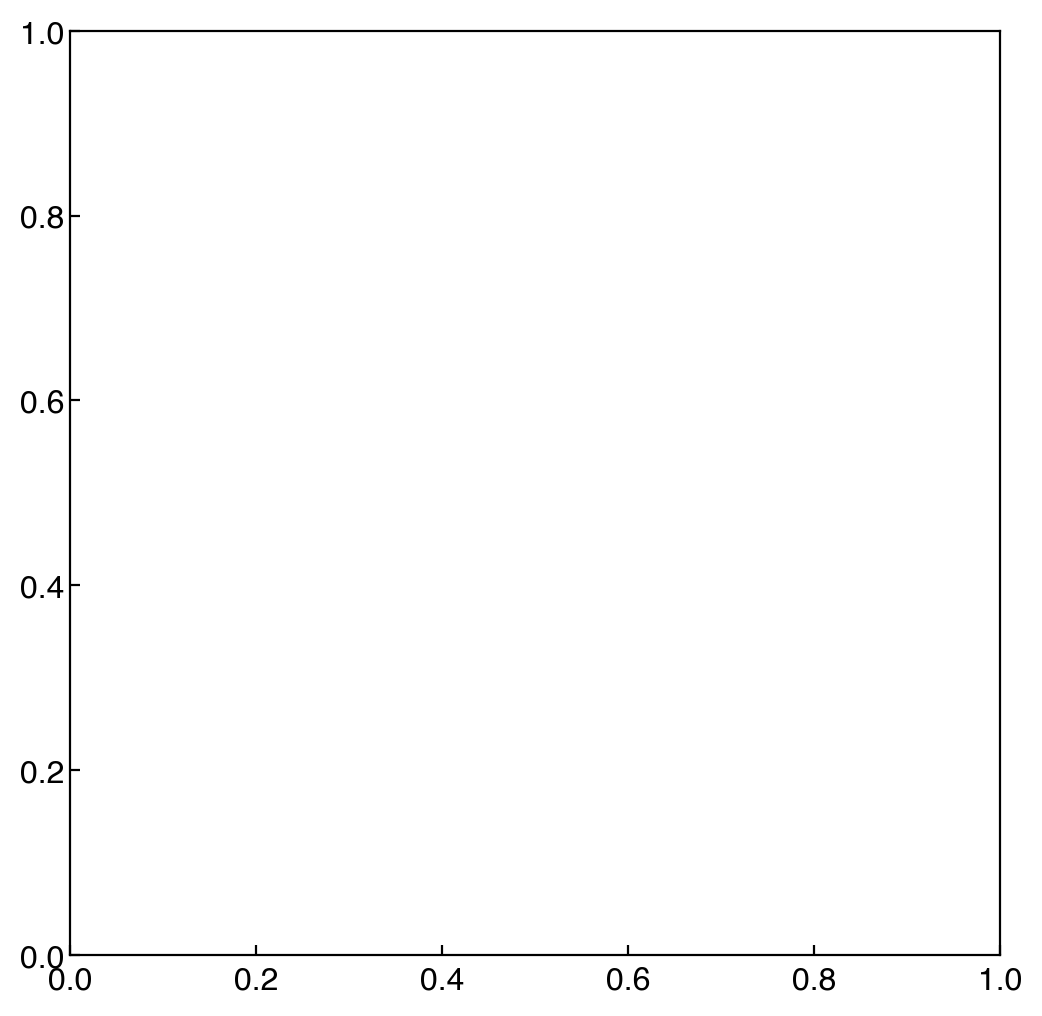

In [11]:
from sumo.plotting import sumo_base_style
plt.style.use(sumo_base_style)
fig,ax = plt.subplots(figsize=(6,6),dpi=200)
pl.single_plot_with_weight(threshold=0.5,s=6,ax=ax,primitive_color='tab:blue',primitive_bs=False)
ax.set_ylabel('Frequency (THz)')
plt.savefig('../test.png')